In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cycler
from scipy import stats
import statsmodels.api as sm

In [3]:
df = pd.read_csv('df1.csv')
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df['dp'] = np.log(df['DP'])
df['dg'] = np.log(df['DG'])
df['r'] = np.log(df['vwRetd'])
df

,year,vwretd,vwretx,vwRetd,vwRetx,rf,Rf,DP,DG,dp,dg,r
0,1927,0.328716,0.266477,1.328716,1.266477,0.0307,1.0307,0.049143,1.170843,-3.013012,0.157724,0.284213
1,1928,0.391397,0.337056,1.391397,1.337056,0.0317,1.0317,0.040642,1.105764,-3.202946,0.100536,0.330308
2,1929,-0.150955,-0.182395,0.849045,0.817605,0.0426,1.0426,0.038454,0.773579,-3.258298,-0.256728,-0.163643
3,1930,-0.289005,-0.321455,0.710995,0.678545,0.0303,1.0303,0.047823,0.843870,-3.040250,-0.169756,-0.341090
4,1931,-0.443873,-0.476969,0.556127,0.523031,0.0148,1.0148,0.063277,0.692053,-2.760228,-0.368092,-0.586759
...,...,...,...,...,...,...,...,...,...,...,...,...
88,2015,-0.015995,-0.037069,0.984005,0.962931,0.0003,1.0003,0.021885,1.008804,-3.821942,0.008766,-0.016124
89,2016,0.129461,0.104250,1.129461,1.104250,0.0023,1.0023,0.022831,1.151962,-3.779641,0.141467,0.121741
90,2017,0.209028,0.184488,1.209028,1.184488,0.0051,1.0051,0.020718,1.074860,-3.876761,0.072190,0.189817
91,2018,-0.061828,-0.081145,0.938172,0.918855,0.0132,1.0132,0.021023,0.932386,-3.862143,-0.070008,-0.063822


In [4]:
rho = np.exp(- df['dp'].mean()) / (1 + np.exp(- df['dp'].mean()))
rho

0.9669445703655455

In [5]:
# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'r'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, 'dp']) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result1 = model.fit()

# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'dg'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, 'dp']) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result2 = model.fit()

# Dependent variable (nparray)
Y = np.array(df.loc[1:, 'dp'])[:, np.newaxis]
# Independent variables (nparray)
X = np.array(df.loc[:df.shape[0] - 2, 'dp']) # .loc will include the tail!!!!!!!!!!
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result3 = model.fit()

In [6]:
br = result1.params[1]
bd = result2.params[1]
phi = result3.params[1]

In [7]:
print('br:', br)
print('bd:', bd)
print('phi:', phi)

br: 0.080573530257287
bd: -0.005364919687349704
phi: 0.9444130978448789


In [8]:
resid_cov = np.cov(np.array([result1.resid, result2.resid, result3.resid]))
resid_cov

array([[ 0.03700938,  0.01874596, -0.01898586],
       [ 0.01874596,  0.02058772,  0.00188119],
       [-0.01898586,  0.00188119,  0.02166944]])

In [9]:
br_lr = br / (1 - rho * phi)
bd_lr = bd / (1 - rho * phi)
print('br_lr:', br_lr)
print('bd_lr:', bd_lr)

br_lr: 0.9282142617508842
bd_lr: -0.06180435375047653


### Simulation

In [10]:
br0 = 0
phi0 = phi
bd0 = br0 + rho * phi0 - 1
bd0

-0.08680488285678967

In [11]:
ar0 = result1.params[0]
ad0 = result2.params[0]
adp0 = result3.params[0]

In [12]:
coef = []

for j in range(5000):
    T = 93
    sample = []
    dp0 = np.mean(df['dp'])
    for i in range(T):
        epsilon = stats.multivariate_normal(mean = [0, 0, 0], cov = resid_cov).rvs()
        epsilon[0] = - rho * epsilon[2] + epsilon[1]
        obs = np.array([ar0, ad0, adp0]) + np.array([br0, bd0, phi0]) * dp0 + epsilon
        sample.append(obs)
        dp0 = obs[2]
    sample = np.array(sample)

    # Dependent variable (nparray)
    Y = sample[1:, 0][:, np.newaxis]
    # Independent variables (nparray)
    X = sample[:-1, 2]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    result1 = model.fit()

    # Dependent variable (nparray)
    Y = sample[1:, 1][:, np.newaxis]
    # Independent variables (nparray)
    X = sample[:-1, 2]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    result2 = model.fit()

    # Dependent variable (nparray)
    Y = sample[1:, 2][:, np.newaxis]
    # Independent variables (nparray)
    X = sample[:-1, 2]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    result3 = model.fit()

    coef.append([result1.params[1], result2.params[1], result3.params[1]])

In [13]:
coef = np.array(coef)
np.mean(np.array(coef), axis = 0)

array([ 0.04408458, -0.09127986,  0.89419351])

In [14]:
print(sum(br < coef[:, 0]) / 5000)
print(sum(bd < coef[:, 1]) / 5000)
print(sum(phi < coef[:, 2]) / 5000)

0.2564
0.0334
0.1748


In [15]:
br_lr_simul = coef[:, 0] / (1 - rho * coef[:, 2])
bd_lr_simul = coef[:, 1] / (1 - rho * coef[:, 2])
print(np.mean(br_lr_simul))
print(np.mean(bd_lr_simul))

0.22930368489794167
-0.7706963151020578


In [16]:
print(sum(br_lr < br_lr_simul) / 5000)
print(sum(bd_lr < bd_lr_simul) / 5000)

0.0426
0.0398


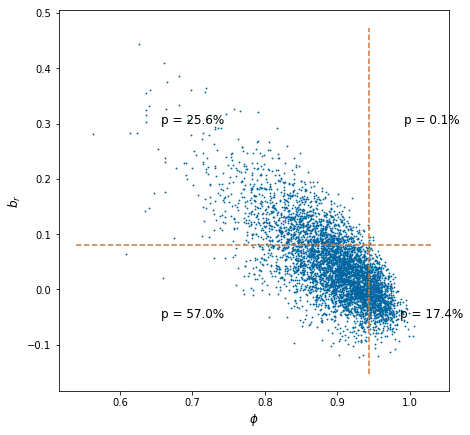

In [17]:
# ax will be an array of Axes objects
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_prop_cycle(cycler('color', ['#0066a1', '#ce753b', '#b85696', '#31686c', '#853c42']))

# Call plot() method on the appropriate object
ax.scatter(coef[:, 2], coef[:, 0], s=0.7)
ax.hlines(br, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], colors = '#ce753b', linestyles='dashed')
ax.vlines(phi, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], colors = '#ce753b', linestyles='dashed')

ax.text(0.7, 0.3, 
        'p = {0:.1f}%'.format(sum(np.array([br < coef[:, 0], phi > coef[:, 2]]).all(axis = 0)) / 5000 * 100),
        ha='center', size=12)
ax.text(1.03, 0.3, 
        'p = {0:.1f}%'.format(sum(np.array([br < coef[:, 0], phi < coef[:, 2]]).all(axis = 0)) / 5000 * 100),
        ha='center', size=12)
ax.text(0.7, -0.05, 
        'p = {0:.1f}%'.format(sum(np.array([br > coef[:, 0], phi > coef[:, 2]]).all(axis = 0)) / 5000 * 100),
        ha='center', size=12)
ax.text(1.03, -0.05, 
        'p = {0:.1f}%'.format(sum(np.array([br > coef[:, 0], phi < coef[:, 2]]).all(axis = 0)) / 5000 * 100),
        ha='center', size=12)


ax.set_xlabel(r'$\phi$', fontsize = 12)
ax.set_ylabel(r'$b_r$', fontsize = 12)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1));

In [18]:
fig.savefig('q3fig1.pdf', format = 'pdf')